# Install Requirements

In [1]:
# !pip install nltk
# nltk.download()
# !pip install -U textblob
# nltk.download('wordnet')
# nltk.download('punkt')
# nltk.download('tagsets')
# !python -m pip install -U pyLDAvis

# Import dependecies

In [2]:
import pandas as pd
import os
import requests 
from bs4 import BeautifulSoup as bs
from pprint import pprint
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from textblob import Word

import gensim 
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim.models.wrappers import LdaMallet

from pyLDAvis import gensim as pgensim
import pyLDAvis.gensim
from gensim.models.phrases import Phrases, Phraser

# Text extraction

In [3]:
cases_df = pd.read_csv('cases_name_year_url.csv')
cases_df.head(2)

,name,year,url
0,MARBURY v. MADISON,1803,https://caselaw.findlaw.com/us-supreme-court/5...
1,GIBBONS v. OGDEN,1824,https://caselaw.findlaw.com/us-supreme-court/2...


In [4]:
#print length of the df
print('length:', len(cases_df))

length: 45


In [5]:
print('shape:', cases_df.shape)

shape: (45, 3)


In [6]:
# List of all the neccesary URLs
urls = list(cases_df['url'])

# Print length to see if it matches the DF
len(urls)

45

In [7]:
# Loop over urls to scrape the texts and append to our empty list

texts = []
list_url = []
list_text = []

counter = 1

for url in urls:
    
    response = requests.get(url)
    soup = bs(response.text,'html.parser')
    results = soup.find_all("div", class_="caselawcontent searchable-content")[0].get_text() 
    list_url.append(url)
    list_text.append(results)
    print(f"Scraped Case: {counter} {url}")
    counter = counter + 1

Scraped Case: 1 https://caselaw.findlaw.com/us-supreme-court/5/137.html
Scraped Case: 2 https://caselaw.findlaw.com/us-supreme-court/22/1.html
Scraped Case: 3 https://caselaw.findlaw.com/us-supreme-court/31/515.html
Scraped Case: 4 https://caselaw.findlaw.com/us-supreme-court/60/393.html
Scraped Case: 5 https://caselaw.findlaw.com/us-supreme-court/94/113.html
Scraped Case: 6 https://caselaw.findlaw.com/us-supreme-court/198/45.html
Scraped Case: 7 https://caselaw.findlaw.com/us-supreme-court/250/616.html
Scraped Case: 8 https://caselaw.findlaw.com/us-supreme-court/262/447.html
Scraped Case: 9 https://caselaw.findlaw.com/us-supreme-court/347/483.html
Scraped Case: 10 https://caselaw.findlaw.com/us-supreme-court/274/200.html
Scraped Case: 11 https://caselaw.findlaw.com/us-supreme-court/36/420.html
Scraped Case: 12 https://caselaw.findlaw.com/us-supreme-court/283/697.html
Scraped Case: 13 https://caselaw.findlaw.com/us-supreme-court/317/111.html
Scraped Case: 14 https://caselaw.findlaw.com

In [8]:
# Create a new df of the scraped text

scraped_text_url = {'url':list_url, 'text':list_text}
scraped_text_url = pd.DataFrame(scraped_text_url)
scraped_text_url.head(2)

,url,text
0,https://caselaw.findlaw.com/us-supreme-court/5...,\n\nUnited States Supreme Court\nMARBURY v. MA...
1,https://caselaw.findlaw.com/us-supreme-court/2...,\n\nUnited States Supreme Court\nGIBBONS v. OG...


In [9]:
# Merge the two dataframes together

cases_df=cases_df.merge(scraped_text_url, on='url')
cases_df.head(2)

,name,year,url,text
0,MARBURY v. MADISON,1803,https://caselaw.findlaw.com/us-supreme-court/5...,\n\nUnited States Supreme Court\nMARBURY v. MA...
1,GIBBONS v. OGDEN,1824,https://caselaw.findlaw.com/us-supreme-court/2...,\n\nUnited States Supreme Court\nGIBBONS v. OG...


In [10]:
cases_df.to_csv("final_data.csv")

# Text Preprocessing

In [11]:
# Remove \n (whitelines)
cases_df = cases_df.replace('\n',' ', regex=True)

# Lowercase
cases_df['text'] = cases_df['text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

# Remove numbers
cases_df['text'] = cases_df['text'].str.replace('\d+', '')
cases_df['text'].head()

<>:8: DeprecationWarning: invalid escape sequence \d
<>:8: DeprecationWarning: invalid escape sequence \d
<>:8: DeprecationWarning: invalid escape sequence \d
<ipython-input-11-59f39f24ab7a>:8: DeprecationWarning: invalid escape sequence \d
  cases_df['text'] = cases_df['text'].str.replace('\d+', '')


0    united states supreme court marbury v. madison...
1    united states supreme court gibbons v. ogden()...
2    united states supreme court worcester v. state...
3    united states supreme court dred scott v. sand...
4    united states supreme court munn v. state of i...
Name: text, dtype: object

In [12]:
cases_df['text'][0]

"united states supreme court marbury v. madison() argued: decided: february ,  at the december term , william marbury, dennis ramsay, robert townsend hooe, and william harper, by their counsel [ u.s. , ] severally moved the court for a rule to james madison, secretary of state of the united states, to show cause why a mandamus should not issue commanding him to cause to be delivered to them respectively their several commissions as justices of the peace in the district of columbia. this motion was supported by affidavits of the following facts: that notice of this motion had been given to mr. madison; that mr. adams, the late president of the united states, nominated the applicants to the senate for their advice and consent to be appointed justices of the peace of the district of columbia; that the senate advised and consented to the appointments; that commissions in due form were signed by the said president appointing them justices, &c. and that the seal of the united states was in d

# Stopwords removal 

In [13]:
stop = stopwords.words('english')

cases_df['text'] = cases_df['text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

cases_df['text'][0][:400]

'united states supreme court marbury v. madison() argued: decided: february , december term , william marbury, dennis ramsay, robert townsend hooe, william harper, counsel [ u.s. , ] severally moved court rule james madison, secretary state united states, show cause mandamus issue commanding cause delivered respectively several commissions justices peace district columbia. motion supported affidavi'

# Sentence tokenization

In [14]:
sent_tokens = cases_df['text']
sent_tokens = sent_tokens.apply(sent_tokenize)
sent_tokens.head()

0    [united states supreme court marbury v. madiso...
1    [united states supreme court gibbons v. ogden(...
2    [united states supreme court worcester v. stat...
3    [united states supreme court dred scott v. san...
4    [united states supreme court munn v. state ill...
Name: text, dtype: object

In [15]:
names = cases_df['name']
names.head(2)

0    MARBURY v. MADISON
1      GIBBONS v. OGDEN
Name: name, dtype: object

In [16]:
# Create a dataframe for sentence tokens to do more text processing below

sent_tokens_df = pd.DataFrame(sent_tokens)
sent_tokens_df.rename(columns={'text': 'sent_tokens'}, inplace= True)
sent_tokens_df.head()

,sent_tokens
0,[united states supreme court marbury v. madiso...
1,[united states supreme court gibbons v. ogden(...
2,[united states supreme court worcester v. stat...
3,[united states supreme court dred scott v. san...
4,[united states supreme court munn v. state ill...


In [17]:
# Join sentence tokens with case names

big_df = sent_tokens_df.join(names)
big_df.head()

,sent_tokens,name
0,[united states supreme court marbury v. madiso...,MARBURY v. MADISON
1,[united states supreme court gibbons v. ogden(...,GIBBONS v. OGDEN
2,[united states supreme court worcester v. stat...,WORCESTER v. STATE OF GA.
3,[united states supreme court dred scott v. san...,DRED SCOTT v. SANDFORD
4,[united states supreme court munn v. state ill...,MUNN v. STATE OF ILLINOIS


# Dataframe for Unique Cases

In [18]:
# Manipulate the dataframe to get topics for only one case
unique_case = big_df.explode('sent_tokens')#.set_index('names').
unique_case.head()

,sent_tokens,name
0,united states supreme court marbury v. madison...,MARBURY v. MADISON
0,motion supported affidavits following facts: n...,MARBURY v. MADISON
0,"rule duly served-- [ u.s. , ] mr. jacob wagner...",MARBURY v. MADISON
0,"court ordered witnesses sworn, answers taken w...",MARBURY v. MADISON
0,"mr. lincoln, acting secretary state, circumsta...",MARBURY v. MADISON


In [19]:
# Unstack dataframe 
unstacked_df = unique_case.set_index(['name',unique_case.groupby('name').cumcount()])['sent_tokens'].unstack().T

In [20]:
unstacked_df.head(3)

name,ABRAMS v. U S,ATLANTA MOTEL v. UNITED STATES,BRANDENBURG v. OHIO,BROWN v. BOARD OF EDUCATION,BUCK v. BELL(1927),BUCKLEY v. VALEO,CHARLES RIVER BRIDGE v. WARREN BRIDGE,CHEVRON US A. v. NATURAL RES. DEF. COUNCIL,CITIZENS UNITED v. FEDERAL ELECTION COMMISSION,COM. OF MASSACHUSETTS v. MELLON,...,ROE v. WADE,SAN ANTONIO SCHOOL DISTRICT v. RODRIGUEZ,STRICKLAND v. WASHINGTON,TERRY v. OHIO,TEXAS v. JOHNSON,UNITED STATES v. NIXON,UNIVERSITY OF CALIFORNIA REGENTS v. BAKKE,WICKARD v. FILBURN,WISCONSIN v. YODER,WORCESTER v. STATE OF GA.
0,united states supreme court abrams v. u s() no.,united states supreme court atlanta motel v. u...,united states supreme court brandenburg v. ohi...,united states supreme court brown v. board edu...,united states supreme court buck v. bell() no.,united states supreme court buckley v. valeo()...,united states supreme court proprietors charle...,united states supreme court chevron u.s. a. v....,united states supreme court citizens united v....,united states supreme court com.,...,united states supreme court roe v. wade() no.,united states supreme court san antonio school...,united states supreme court strickland v. wash...,united states supreme court terry v. ohio() no.,united states supreme court texas v. johnson()...,united states supreme court united states v. n...,united states supreme court university califor...,united states supreme court wickard v. filburn...,united states supreme court wisconsin v. yoder...,united states supreme court worcester v. state...
1,"argued: decided: november , mr. harry weinberg...","argued: october , decided: december , appellan...","argued: february , decided: june , appellant, ...","argued: december , decided: may , segregation ...","argued: april , decided: may , [ u.s. , ] mr. ...","- argued: november , decided: january , [ foot...",plaintiffs error corporation created act legis...,def.,"- argued: march , decided: january , amended §...",massachusetts v. mellon() argued: decided: jun...,...,"- argued: december , decided: january , pregna...","- argued: october , decided: march , financing...","- argued: january , decided: may , respondent ...","argued: december , decided: june , cleveland d...","- argued: march , decided: june , republican n...","- argued: july , decided: july , [ footnote * ...","- argued: october , decided: june , medical sc...","argued: october , decided: november , appeal d...","- argued: december , decided: may , respondent...","argued: decided: january , [ u.s. , ] writ err..."
2,mr. assistant attorney general robert p. stewa...,three-judge district court upheld constitution...,.,pp.,"[ u.s. , ] mr. a. e. strode, lynchburg, va., d...","-, buckley et al.","preamble act stated, 'whereas, erecting bridge...",council() no.,u. s. c. §b.,"[ u.s. , ] messrs. alexander lincoln j. weston...",...,"licensed physician (hallford), two state abort...",almost half revenues derived largely state-fun...,"plea colloquy, respondent told trial judge tha...",saw proceed alternately back forth along ident...,"march city streets, johnson burned american fl...","-, nixon, president united states v. united st...","regular procedure, candidates whose overall un...","messrs. francis biddle, atty.",evidence showed amish provide continuing infor...,"december , legislature state georgia passed fo..."


In [21]:
# Select a case
case1 = unstacked_df['MIRANDA v. ARIZONA']
case1 = pd.DataFrame(case1).dropna()
case1.head() 

,MIRANDA v. ARIZONA
0,united states supreme court miranda v. arizona...
1,"argued: decided: june , [ footnote * ] togethe..."
2,", vignera v. new york, certiorari court appeal..."
3,", westover v. united states, certiorari united..."
4,", california v. stewart, certiorari supreme co..."


# Preprocessing

In [22]:
# Remove irrelevant words
irrelevant_words = ['ii','iii','footnote','www','jiii'] 

case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].str.replace('|'.join(irrelevant_words), '')

In [23]:
# Remove punctuation
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].str.replace('[^\w\s]','')

# Remove words if length less than 1
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

# Lemmatize
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(lambda x: " ".join([Word(word).lemmatize('v') for word in x.split()]))

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-23-59750b673b4b>:2: DeprecationWarning: invalid escape sequence \w
  case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].str.replace('[^\w\s]','')


In [24]:
# Tokenization of words for case 1
case1['MIRANDA v. ARIZONA'] = case1['MIRANDA v. ARIZONA'].apply(nltk.word_tokenize)

In [25]:
# Remove empty lists

case1 = case1[case1.astype(str)['MIRANDA v. ARIZONA'] != '[]']

In [26]:
# Convert string to list values
data = case1.values.tolist()

In [27]:
case1 = case1['MIRANDA v. ARIZONA']
case1

0        [unite, state, supreme, court, miranda, arizona]
1                         [argue, decide, june, together]
2       [vignera, new, york, certiorari, court, appeal...
3       [westover, unite, state, certiorari, unite, st...
4       [california, stewart, certiorari, supreme, cou...
                              ...                        
1761    [perhaps, equal, significance, number, instanc...
1762                     [serious, know, offenses, clear]
1763         [clearance, rate, range, homicides, larceny]
1764                        [fbi, uniform, crime, report]
1765    [would, replace, interrogation, investigatoria...
Name: MIRANDA v. ARIZONA, Length: 1499, dtype: object

In [28]:
# Create a dataframe for MIRANDA v. ARIZONA
case1_df = pd.DataFrame(case1)
case1_df.head()

,MIRANDA v. ARIZONA
0,"[unite, state, supreme, court, miranda, arizona]"
1,"[argue, decide, june, together]"
2,"[vignera, new, york, certiorari, court, appeal..."
3,"[westover, unite, state, certiorari, unite, st..."
4,"[california, stewart, certiorari, supreme, cou..."


In [29]:
case1_df.head(2)

,MIRANDA v. ARIZONA
0,"[unite, state, supreme, court, miranda, arizona]"
1,"[argue, decide, june, together]"


# Topic Modeling for 'MIRANDA v. ARIZONA'

# LDA Mallet Modeling

In [30]:
# Create Dictionary
id2word = corpora.Dictionary(case1)

# Create Corpus
texts = case1

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]]


In [31]:
mallet_path = '/Users/gresamurati/Downloads/mallet-2.0.8/bin/mallet' 
ldamallet = LdaMallet(mallet_path, corpus=corpus, num_topics=5, id2word=id2word)

# Show Topics

pprint(ldamallet.show_topics(formatted=True))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=case1, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  '0.045*"counsel" + 0.041*"privilege" + 0.034*"confession" + 0.034*"warn" + '
  '0.029*"accuse" + 0.021*"person" + 0.018*"arrest" + 0.017*"trial" + '
  '0.017*"obtain" + 0.016*"statements"'),
 (1,
  '0.099*"court" + 0.046*"case" + 0.033*"rule" + 0.026*"confessions" + '
  '0.026*"amendment" + 0.026*"give" + 0.019*"present" + 0.016*"compel" + '
  '0.015*"rev" + 0.014*"process"'),
 (2,
  '0.068*"interrogation" + 0.040*"make" + 0.036*"law" + 0.024*"statement" + '
  '0.023*"individual" + 0.018*"enforcement" + 0.015*"today" + 0.015*"decision" '
  '+ 0.014*"require" + 0.014*"fact"'),
 (3,
  '0.080*"state" + 0.064*"police" + 0.034*"unite" + 0.030*"criminal" + '
  '0.027*"evidence" + 0.015*"justice" + 0.012*"general" + 0.010*"crime" + '
  '0.010*"york" + 0.008*"view"'),
 (4,
  '0.044*"question" + 0.026*"defendant" + 0.024*"attorney" + 0.021*"time" + '
  '0.019*"federal" + 0.017*"officer" + 0.017*"hold" + 0.015*"silent" + '
  '0.014*"remain" + 0.013*"prior"')]

Coherence Score:  0.34092057

In [32]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [33]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=case1, start=2, limit=40, step=6)

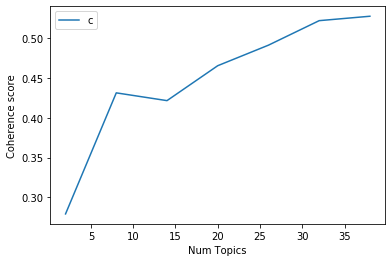

In [34]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()


In [35]:
mlist = []
cvlist = []

# Print the coherence scores
for m, cv in zip(x, coherence_values):
    mlist.append(m)
    cvlist.append(cv)
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))
    
best_coherence = pd.DataFrame({"m":mlist,"cv":cvlist})
best_index = best_coherence.idxmax()[0]

Num Topics = 2  has Coherence Value of 0.2793
Num Topics = 8  has Coherence Value of 0.4313
Num Topics = 14  has Coherence Value of 0.4215
Num Topics = 20  has Coherence Value of 0.4654
Num Topics = 26  has Coherence Value of 0.4912
Num Topics = 32  has Coherence Value of 0.5219
Num Topics = 38  has Coherence Value of 0.5275


In [36]:
# Select the model and print the topics
optimal_model = model_list[best_index]
model_topics = optimal_model.show_topics(formatted=True)
pprint(optimal_model.print_topics(num_words=10))

[(12,
  '0.106*"justice" + 0.062*"report" + 0.044*"american" + 0.026*"government" + '
  '0.026*"commission" + 0.026*"study" + 0.023*"civil" + 0.023*"administration" '
  '+ 0.023*"special" + 0.023*"respect"'),
 (25,
  '0.094*"constitutional" + 0.083*"constitution" + 0.068*"witness" + '
  '0.046*"deal" + 0.031*"issue" + 0.026*"read" + 0.026*"role" + 0.023*"assume" '
  '+ 0.020*"face" + 0.017*"provision"'),
 (23,
  '0.204*"evidence" + 0.202*"accuse" + 0.039*"guilty" + 0.036*"put" + '
  '0.036*"guilt" + 0.034*"wigmore" + 0.018*"examples" + 0.018*"mcnaughton" + '
  '0.018*"person" + 0.016*"respect"'),
 (19,
  '0.104*"process" + 0.095*"case" + 0.057*"due" + 0.041*"pressure" + '
  '0.038*"cir" + 0.035*"conduct" + 0.033*"matter" + 0.030*"confess" + '
  '0.027*"outset" + 0.022*"atmosphere"'),
 (13,
  '0.103*"subject" + 0.062*"suspect" + 0.054*"long" + 0.051*"describe" + '
  '0.043*"place" + 0.032*"interrogator" + 0.027*"comment" + '
  '0.019*"psychological" + 0.019*"require" + 0.019*"judge"'),


In [37]:
# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=optimal_model, texts=case1, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

print(f'Coherence Score for Optimal Model: {coherence_ldamallet}')

Coherence Score for Optimal Model: 0.5274750851389206


# More text preprocessing for dataframe that includes all landmark cases

In [38]:
big_df.head()

,sent_tokens,name
0,[united states supreme court marbury v. madiso...,MARBURY v. MADISON
1,[united states supreme court gibbons v. ogden(...,GIBBONS v. OGDEN
2,[united states supreme court worcester v. stat...,WORCESTER v. STATE OF GA.
3,[united states supreme court dred scott v. san...,DRED SCOTT v. SANDFORD
4,[united states supreme court munn v. state ill...,MUNN v. STATE OF ILLINOIS


In [39]:
# Remove brackets from list
big_df['sent_tokens'] = big_df['sent_tokens'].apply(lambda x: ",".join(x) if isinstance(x, list) else x)

# Remove punctuation
big_df['sent_tokens']  = big_df['sent_tokens'].str.replace('[^\w\s]','')

# Remove words if length less than 1
big_df['sent_tokens']  = big_df['sent_tokens'] .apply(lambda x: ' '.join([w for w in x.split() if len(w)>1]))
big_df['sent_tokens'].head()
big_df.head()

<>:5: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \w
<>:5: DeprecationWarning: invalid escape sequence \w
<ipython-input-39-b3feb3dbe335>:5: DeprecationWarning: invalid escape sequence \w
  big_df['sent_tokens']  = big_df['sent_tokens'].str.replace('[^\w\s]','')


,sent_tokens,name
0,united states supreme court marbury madison ar...,MARBURY v. MADISON
1,united states supreme court gibbons ogden noar...,GIBBONS v. OGDEN
2,united states supreme court worcester state ga...,WORCESTER v. STATE OF GA.
3,united states supreme court dred scott sandfor...,DRED SCOTT v. SANDFORD
4,united states supreme court munn state illinoi...,MUNN v. STATE OF ILLINOIS


## Lemmatization

In [40]:
big_df['sent_tokens']  = big_df['sent_tokens'] .apply(lambda x: " ".join([Word(word).lemmatize('v') for word in x.split()]))

big_df.head()

,sent_tokens,name
0,unite state supreme court marbury madison argu...,MARBURY v. MADISON
1,unite state supreme court gibbons ogden noargu...,GIBBONS v. OGDEN
2,unite state supreme court worcester state ga n...,WORCESTER v. STATE OF GA.
3,unite state supreme court dred scott sandford ...,DRED SCOTT v. SANDFORD
4,unite state supreme court munn state illinois ...,MUNN v. STATE OF ILLINOIS


In [41]:
big_df['sent_tokens'][0][:400]

'unite state supreme court marbury madison argue decide february december term william marbury dennis ramsay robert townsend hooe william harper counsel us severally move court rule jam madison secretary state unite state show cause mandamus issue command cause deliver respectively several commission justices peace district columbiamotion support affidavits follow facts notice motion give mr madiso'

In [42]:
big_df['sent_tokens'][0].find('footnote')

-1

In [43]:
# Remove irrelevant words

words = ['ii','iii','footnote','www','jiii','fs','unite','state','court','law'] 

for word in list(words):  
    if word in big_df['sent_tokens']:
        words.remove(word)

In [44]:
big_df['sent_tokens'][0].find('footnote')

-1

In [45]:
# Set variable for sentence tokens to do word tokenization below
sentence_tokens = big_df['sent_tokens']
sentence_tokens.head()

0    unite state supreme court marbury madison argu...
1    unite state supreme court gibbons ogden noargu...
2    unite state supreme court worcester state ga n...
3    unite state supreme court dred scott sandford ...
4    unite state supreme court munn state illinois ...
Name: sent_tokens, dtype: object

In [46]:
names = cases_df['name']

In [47]:
sent_tokens_df =pd.DataFrame(sentence_tokens)
sent_tokens_df.head()

,sent_tokens
0,unite state supreme court marbury madison argu...
1,unite state supreme court gibbons ogden noargu...
2,unite state supreme court worcester state ga n...
3,unite state supreme court dred scott sandford ...
4,unite state supreme court munn state illinois ...


#  Word tokenization



In [48]:
text_tokens = sentence_tokens.apply(word_tokenize)
text_tokens.head()

0    [unite, state, supreme, court, marbury, madiso...
1    [unite, state, supreme, court, gibbons, ogden,...
2    [unite, state, supreme, court, worcester, stat...
3    [unite, state, supreme, court, dred, scott, sa...
4    [unite, state, supreme, court, munn, state, il...
Name: sent_tokens, dtype: object

In [49]:
text_tokens_df = pd.DataFrame(text_tokens)
text_tokens_df = text_tokens_df.rename(columns={'sent_tokens': 'word_tokens'})
text_tokens_df.head()

,word_tokens
0,"[unite, state, supreme, court, marbury, madiso..."
1,"[unite, state, supreme, court, gibbons, ogden,..."
2,"[unite, state, supreme, court, worcester, stat..."
3,"[unite, state, supreme, court, dred, scott, sa..."
4,"[unite, state, supreme, court, munn, state, il..."


In [50]:
# List of tokens for every case

listy = []
for i in range(len(text_tokens_df['word_tokens'])):
    listy.append(text_tokens_df['word_tokens'][i])

### Part-Of-Speech Tagging

In [51]:
# Get POS tags with NLTK
pos_tag = text_tokens.apply(nltk.pos_tag)
pos_tag.head()

0    [(unite, JJ), (state, NN), (supreme, JJ), (cou...
1    [(unite, JJ), (state, NN), (supreme, JJ), (cou...
2    [(unite, JJ), (state, NN), (supreme, JJ), (cou...
3    [(unite, JJ), (state, NN), (supreme, JJ), (cou...
4    [(unite, JJ), (state, NN), (supreme, JJ), (cou...
Name: sent_tokens, dtype: object

In [52]:
# Find out the meaning of specific tags

nltk.help.upenn_tagset("JJ")
nltk.help.upenn_tagset("NN")

JJ: adjective or numeral, ordinal
    third ill-mannered pre-war regrettable oiled calamitous first separable
    ectoplasmic battery-powered participatory fourth still-to-be-named
    multilingual multi-disciplinary ...
NN: noun, common, singular or mass
    common-carrier cabbage knuckle-duster Casino afghan shed thermostat
    investment slide humour falloff slick wind hyena override subhumanity
    machinist ...


In [53]:
# Convert series to dataframe
pos_tag_df = pd.Series(pos_tag,
               name="POS_tags")
pos_tag_df.to_frame().head()

,POS_tags
0,"[(unite, JJ), (state, NN), (supreme, JJ), (cou..."
1,"[(unite, JJ), (state, NN), (supreme, JJ), (cou..."
2,"[(unite, JJ), (state, NN), (supreme, JJ), (cou..."
3,"[(unite, JJ), (state, NN), (supreme, JJ), (cou..."
4,"[(unite, JJ), (state, NN), (supreme, JJ), (cou..."


In [54]:
# Merge the two dataframes together

text_and_tokens = pd.concat([cases_df, text_tokens_df], axis=1)
text_and_tokens.head()

,name,year,url,text,word_tokens
0,MARBURY v. MADISON,1803,https://caselaw.findlaw.com/us-supreme-court/5...,united states supreme court marbury v. madison...,"[unite, state, supreme, court, marbury, madiso..."
1,GIBBONS v. OGDEN,1824,https://caselaw.findlaw.com/us-supreme-court/2...,united states supreme court gibbons v. ogden()...,"[unite, state, supreme, court, gibbons, ogden,..."
2,WORCESTER v. STATE OF GA.,1832,https://caselaw.findlaw.com/us-supreme-court/3...,united states supreme court worcester v. state...,"[unite, state, supreme, court, worcester, stat..."
3,DRED SCOTT v. SANDFORD,1856,https://caselaw.findlaw.com/us-supreme-court/6...,united states supreme court dred scott v. sand...,"[unite, state, supreme, court, dred, scott, sa..."
4,MUNN v. STATE OF ILLINOIS,1876,https://caselaw.findlaw.com/us-supreme-court/9...,united states supreme court munn v. state illi...,"[unite, state, supreme, court, munn, state, il..."


# Exploring the Data

In [55]:
# TF-IDF

frequency_dist = text_tokens.apply(nltk.FreqDist)
frequency_dist.head(10)

0    {'unite': 48, 'state': 76, 'supreme': 18, 'cou...
1    {'unite': 168, 'state': 962, 'supreme': 17, 'c...
2    {'unite': 214, 'state': 456, 'supreme': 32, 'c...
3    {'unite': 583, 'state': 1581, 'supreme': 67, '...
4    {'unite': 18, 'state': 113, 'supreme': 10, 'co...
5    {'unite': 8, 'state': 92, 'supreme': 8, 'court...
6    {'unite': 46, 'state': 44, 'supreme': 2, 'cour...
7    {'unite': 8, 'state': 67, 'supreme': 2, 'court...
8    {'unite': 13, 'state': 37, 'supreme': 4, 'cour...
9    {'unite': 1, 'state': 7, 'supreme': 3, 'court'...
Name: sent_tokens, dtype: object

In [56]:
# Convert list of tokens for MIRANDA v. ARIZONA to strings

case1_df['liststringCase1'] = [','.join(map(str, l)) for l in case1_df['MIRANDA v. ARIZONA']]
case1_df['liststringCase1']

0               unite,state,supreme,court,miranda,arizona
1                              argue,decide,june,together
2       vignera,new,york,certiorari,court,appeal,new,york
3       westover,unite,state,certiorari,unite,state,co...
4       california,stewart,certiorari,supreme,court,ca...
                              ...                        
1761    perhaps,equal,significance,number,instance,kno...
1762                          serious,know,offenses,clear
1763               clearance,rate,range,homicides,larceny
1764                             fbi,uniform,crime,report
1765    would,replace,interrogation,investigatorial,to...
Name: liststringCase1, Length: 1499, dtype: object

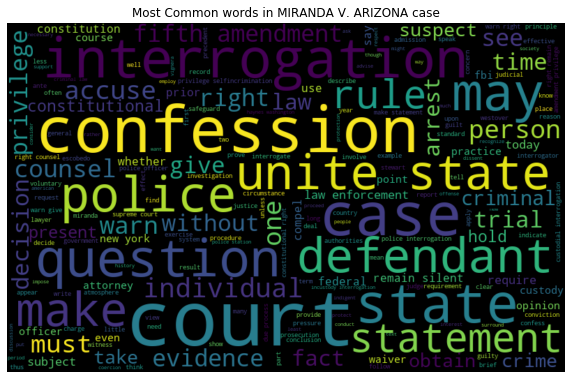

In [57]:
# Wordcloud

all_words = ' '.join([text for text in case1_df['liststringCase1']])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title("Most Common words in MIRANDA V. ARIZONA case")
plt.show()

# Creating Bigram and Trigram Models for all cases

In [58]:
# Build the bigram and trigram models

bigram = Phrases(listy, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[listy], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = Phraser(bigram)
trigram_mod = Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[listy[0]]])

['unite', 'state', 'supreme', 'court', 'marbury_madison', 'argue', 'decide', 'february', 'december', 'term', 'william', 'marbury', 'dennis', 'ramsay', 'robert', 'townsend', 'hooe', 'william', 'harper', 'counsel', 'us', 'severally', 'move', 'court', 'rule', 'jam_madison', 'secretary', 'state', 'unite', 'state', 'show', 'cause', 'mandamus', 'issue', 'command', 'cause', 'deliver', 'respectively', 'several', 'commission', 'justices', 'peace', 'district', 'columbiamotion', 'support', 'affidavits', 'follow', 'facts', 'notice', 'motion', 'give', 'mr_madison', 'mr', 'adams', 'late', 'president', 'unite', 'state', 'nominate', 'applicants', 'senate', 'advice_consent', 'appoint', 'justices', 'peace', 'district_columbia', 'senate', 'advise', 'consent', 'appointments', 'commission', 'due', 'form', 'sign', 'say', 'president', 'appoint', 'justices', 'seal', 'unite', 'state', 'due', 'form', 'affix', 'say', 'commission', 'secretary', 'state', 'applicants', 'request', 'mr_madison', 'deliver', 'say', 'co

In [59]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [60]:
# Form Bigrams
data_words_bigrams = make_bigrams(listy)
data_words_bigrams 

[['unite',
  'state',
  'supreme',
  'court',
  'marbury_madison',
  'argue',
  'decide',
  'february',
  'december',
  'term',
  'william',
  'marbury',
  'dennis',
  'ramsay',
  'robert',
  'townsend',
  'hooe',
  'william',
  'harper',
  'counsel',
  'us',
  'severally',
  'move',
  'court',
  'rule',
  'jam_madison',
  'secretary',
  'state',
  'unite',
  'state',
  'show',
  'cause',
  'mandamus',
  'issue',
  'command',
  'cause',
  'deliver',
  'respectively',
  'several',
  'commission',
  'justices',
  'peace',
  'district',
  'columbiamotion',
  'support',
  'affidavits',
  'follow',
  'facts',
  'notice',
  'motion',
  'give',
  'mr_madison',
  'mr',
  'adams',
  'late',
  'president',
  'unite',
  'state',
  'nominate',
  'applicants',
  'senate',
  'advice_consent',
  'appoint',
  'justices',
  'peace',
  'district_columbia',
  'senate',
  'advise',
  'consent',
  'appointments',
  'commission',
  'due',
  'form',
  'sign',
  'say',
  'president',
  'appoint',
  'justices'

# LDA Modeling for all cases

In [61]:
# Create Dictionary
id2word = corpora.Dictionary(listy)

# Create Corpus
texts = listy

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 2), (8, 1), (9, 1), (10, 4), (11, 3), (12, 1), (13, 1), (14, 5), (15, 1), (16, 1), (17, 1), (18, 1), (19, 72), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 2), (26, 2), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 2), (34, 7), (35, 1), (36, 1), (37, 1), (38, 6), (39, 4), (40, 1), (41, 15), (42, 5), (43, 1), (44, 1), (45, 1), (46, 2), (47, 2), (48, 1), (49, 1), (50, 2), (51, 2), (52, 1), (53, 4), (54, 2), (55, 2), (56, 1), (57, 1), (58, 2), (59, 1), (60, 1), (61, 2), (62, 1), (63, 2), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 2), (70, 1), (71, 1), (72, 1), (73, 4), (74, 1), (75, 1), (76, 1), (77, 3), (78, 1), (79, 5), (80, 13), (81, 1), (82, 2), (83, 6), (84, 4), (85, 3), (86, 1), (87, 10), (88, 1), (89, 27), (90, 1), (91, 40), (92, 1), (93, 1), (94, 1), (95, 2), (96, 1), (97, 1), (98, 3), (99, 1), (100, 1), (101, 4), (102, 1), (103, 1), (104, 1), (105, 4), (106, 1), (107, 2), (108, 1), (109, 2), (1

In [ ]:
# Create a loop to find the best topic modeling number
counter_num = 2
list_coherence = []
list_num_topics = []

for i in range(2,4,1):
    mallet_path = '/Users/gresamurati/Downloads/mallet-2.0.8/bin/mallet' 
    model = LdaMallet(mallet_path, corpus=corpus, num_topics=i, id2word=id2word)
    print(i)
    cohe_score = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence()
    list_coherence.append(cohe_score)
    list_num_topics.append(i)
    counter_num = counter_num + 1

2


In [ ]:
# Save the coherence scores and topic numbers to find the optimal score
best_coherence_cases = pd.DataFrame({'num_topics': list_num_topics, 'Coherence Score': list_coherence})
best_index = best_coherence_cases['Coherence Score'].idxmax()
best_index

In [ ]:
best_coherence_cases.head()

In [ ]:
# Best Coherence score
a = best_coherence_cases['num_topics'][best_index]

In [ ]:
# Show graph

plt.plot(best_coherence_cases['num_topics'], best_coherence_cases['Coherence Score'])
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
mallet_path = '/Users/gresamurati/Downloads/mallet-2.0.8/bin/mallet' 
model = LdaMallet(mallet_path, corpus=corpus, num_topics=a, id2word=id2word)
cohe_score = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence='c_v').get_coherence()
print(cohe_score)

In [ ]:
# Show Topics

pprint(model.show_topics(formatted=True))

In [ ]:
#print model.print_topics(Nwords=5)

In [ ]:
#years, representation = model.topic_over_time(5)

In [ ]:
# Wrappped LDAMallet into LDA to plot with pyLDAvis

modely = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(model)

In [ ]:
# Visualize the topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(modely, corpus, id2word)
vis